`K. Ong | Fall 2018`

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np
import re
import string
import collections
import matplotlib.pyplot as plt
import time 

import sys
sys.path.insert(0, 'helpers/')
from helper_base import *
from helper_prep import *
from helper_model import *

from gensim.models import Word2Vec

In [6]:
df = pd.read_csv('../df_output_20181213_1004.csv')

Below we create a lemmatized version of the text field since our n-grams were identified on lemmas:

In [84]:
df['tokenized_text'] = df.reviews_regram.apply(lambda x: ' '.join(retokenize(x))) 

In [85]:
display_all(df[:1])

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_year,reviews_clean,reviews_regram,tokenized_text
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013",2013,just another flavor of kit kat but the taste i...,just another flavor of kit kat but the taste i...,another flavor kit kat taste unique bit differ...


In [9]:
df.shape

(51894, 12)

# Vectorization

The function `get_vecs()` applies both count vectorization and TF-IDF vectorization to the text field. Both variations can then be passed into the topic models for consideration. 

In [18]:
sentences = df.reviews_regram
cv_features, cv_docs, tf_features, tf_docs = get_vecs(sentences)

Num. Features (Count Vec):  46891
Num. Features (TFIDF Vec):  46891

Dim. Docs (Count Vec):  (51894, 46891)
Dim. Docs (TFIDF Vec):  (51894, 46891)


Below we try two topic models: Latent Dirichlet Allocation-based modelling using [gensim's LDA model](https://radimrehurek.com/gensim/models/ldamodel.html), as well as Greg Ver Steeg's [Correlation Explanation (CorEx)](https://github.com/gregversteeg/corex_topic) model. We found that CorEx was more effective than LDA on our survey data, possibly due to the small data size. It also provides a simple way to seed/anchor tokens of interest. 

The functions `get_gensim_topics()` and `get_corex_topics()` run both models using grid search on the hyperparameter `n`, the number of topics to generate, and calculate the key metric for each variation - coherence for LDA and correlation for CorEx. `pick_top_n()` then finds the hyperparameter(s) `n` that maximize(s) coherence/correlation so that we can view the optimal model(s) output.

For grid search, we used `list(range(12,32,2))`, though this range is pretty variable. Just note that perplexity monotonically decreases as `n` increases, coherence goes up and down, and higher `n` is obviously harder to interpret by eye. For the purposes of this demo, we'll apply grid search on a smaller range. 

## LDA

In [20]:
num_topics_gensim = list(range(12,22,2))
perplexity, coherence = get_gensim_topics(num_topics_gensim, sentences)

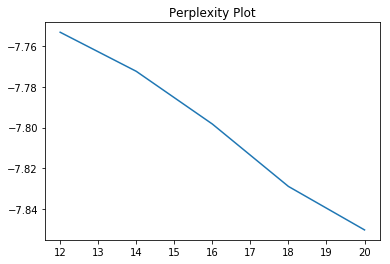

In [25]:
plt.plot(num_topics_gensim, perplexity)
plt.title('Perplexity Plot')
plt.show()

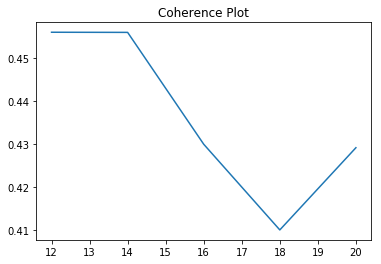

In [26]:
plt.plot(num_topics_gensim, coherence)
plt.title('Coherence Plot')
plt.show()

In [29]:
top_n = pick_top_n(coherence, num_topics_gensim, 1)

Best Num. Topics:  [12]


In [30]:
_,_ = get_gensim_topics(top_n, sentences, print_flag = True)

Num. Topics:  12

cooky , make , sugar , add , cookie , use , water , cup , mix , sweet
popcorn , salt , bag , package , product , use , open , pop , would , corn
fat , ingredient , calorie , oil , use , coconut_oil , product , contain , organic , gram
price , buy , product , find , use , love , great , make , amazon , good
flavor , like , taste , try , would , one , good , really , drink , chocolate
use , tuna , make , work , easy , great , well , mix , come , container
snack , love , one , like , bag , get , eat , buy , good , box
like , taste , eat , would , good , try , think , bar , really , flavor
rice , add , soup , sauce , flavor , cook , make , garlic , chicken , couscous
coffee , cup , brew , kcup , keurig , blend , filter , use , machine , k
tea , like , taste , flavor , make , lipton , one , use , try , get
get , take , day , like , go , use , try , put , milk , one



We can already see that we have more or less cohesive topics around: cookies, popcorn, oil, coffee, tea

## Corex with Count Vectorization

Below, we run a version of the CorEx model using the count vectorization method. Note that you can also run a version with TF-IDF vectorization, using `tf_features` and `tf_docs` created above, and compare outputs. We generally found that as we were mostly interested in finding topics that were most representative in terms of volume/frequency, count vectorization was more effective.

Let's use the same set of numbers we used in the gensim model for CorEx grid search.

In [32]:
correlation = get_corex_topics(num_topics_gensim, cv_docs, cv_features)

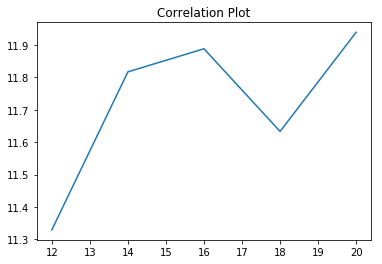

In [33]:
plt.plot(num_topics_gensim, correlation)
plt.title('Correlation Plot')
plt.show()

In [34]:
top_n_corex = pick_top_n(correlation, num_topics_gensim, 1)

Best Num. Topics:  [20]


In [35]:
_ = get_corex_topics(top_n_corex, cv_docs, cv_features, print_flag = True)

Num topics:  20
1: like, would, try, taste, think, one, say, first, much, bit
2: coffee, tea, cup, brew, drink, strong, kcup, keurig, kcups, green_tea
3: calorie, fat, ingredient, contain, gram, per, sugar, serving, protein, sodium
4: oil, skin, coconut_oil, vitamin, help, calcium, iron, health, hair, process
5: sauce, chicken, soup, cook, garlic, dish, cheese, onion, pepper, noodle
6: add, minute, make, water, easy, microwave, boil, direction, prepare, let
7: formula, pad, cleaner, cook_top, handle, enfamil, cleaning, baby, infant, scrub
8: review, product, star, come, however, since, read, note, plastic, another
9: snack, chocolate, eat, apple, bar, sweet, crunchy, cooky, fruit, nut
10: open, bag, package, take, get, two, keep, container, small, size
11: company, new, acid, system, become, show, oz, consumer, bean, american
12: amazon, price, save, subscribe, buy, find, store, pay, local, sell
13: use, mix, recipe, bake, butter, milk, powder, egg, popcorn, dry
14: gluten, pasta, free

We can see that there are topics that emerge around coffee/tea, nutritional content, preparations, prices, pasta, and sweetener.

## Anchored CorEx

We can use the words outputted from LDA and CorEx to anchor a CorEx model with the following specifications:
- 8 topics are anchored using a maximum of 6 words per topic
- `n_hidden=12` means the model will try to elicit 12 topics; this also means the model can find up to 4 topics unrelated to the anchors
- `anchor_strength=4` anchors a topic relatively strongly to the words

See the section Semi-Supervised Topic Modelling on [this](https://github.com/gregversteeg/corex_topic) page for more details.

In [41]:
topic_model = ct.Corex(n_hidden=16, seed = 10)  
topic_model.fit(cv_docs, words=cv_features,\
                anchors = [['coffee', 'tea', 'cup', 'brew', 'drink', 'keurig'],\
                           ['calorie', 'fat', 'ingredient', 'serving', 'sodium'],\
                           ['add', 'minute', 'microwave', 'boil', 'direction', 'prepare'],\
                           ['price', 'save', 'subscribe', 'pay', 'local'],\
                           ['gluten', 'pasta', 'flour', 'barilla', 'wheat', 'spaghetti'],\
                           ['honey', 'stevia', 'sweeten', 'sweetener'],\
                           ['cooky', 'cookie', 'sugar', 'mix'],\
                           ['popcorn', 'pop', 'corn', 'salt', 'bag', 'package'],\
                           ['fat', 'calorie', 'oil', 'coconut_oil']\
                          ], anchor_strength=4) #, docs=docs))

topics = topic_model.get_topics()
for topic_n,topic in enumerate(topics):
    words,mis = zip(*topic)
    topic_str = str(topic_n+1)+': '+', '.join(words)
    print(topic_str)

1: coffee, cup, drink, tea, brew, keurig, strong, kcup, kcups, green_tea
2: ingredient, calorie, fat, serving, sodium, gram, contain, per, serve, protein
3: add, minute, prepare, microwave, boil, direction, cook, dish, easy, chicken
4: price, save, pay, subscribe, local, amazon, money, cost, cheaper, reasonably
5: gluten, pasta, flour, wheat, barilla, spaghetti, free, sauce, bread, recipe
6: honey, sweetener, sweeten, stevia, natural, help, effect, bottle, health, benefit
7: sugar, mix, cooky, cookie, milk, keebler, chocolate_chip, shortbread, pancake, vanilla
8: bag, package, salt, popcorn, pop, corn, kernel, salty, resealable, orville
9: calorie, oil, fat, coconut_oil, saturate, trans, cholesterol, skin, vitamin, olive_oil
10: one, get, go, first, even, could, know, take, thing, see
11: flavor, note, nice, side, slightly, enjoy, type, mild, color, either
12: would, try, think, taste, say, give, much, bit, something, review
13: use, make, water, also, well, open, top, put, time, need


# Custom Word2Vec Model

Let's say we're happy with the ten more-or-less coherent topics that emerge above. We can now estimate the proportion of reviews that contain each topic by applying string matches on the constituent words. One way to find additional tokens that are relevant to a topic is to use word embeddings. These come from a Word2Vec model trained on our corpus in [this](insert link) notebook.

In [102]:
model_big = Word2Vec.load("../word2vec_all.model")

The `gensim` model has a `most_similar()` function which enables us to retrieve the top n tokens most similar (i.e. closest in n-dimensional space) to one given.

For instance, below are the top 10 tokens most similar to 'coffee'. Notice, interestingly, that Word2Vec is an effective way to identify and overcome typos. 

In [111]:
model_big.most_similar(positive = ['coffee'], topn=10)

[('coffe', 0.8115454912185669),
 ('espresso', 0.8087444305419922),
 ('java', 0.7499706745147705),
 ('coffees', 0.7019534111022949),
 ('cappuccino', 0.6990188360214233),
 ('brew', 0.6959743499755859),
 ('decaf', 0.6938413381576538),
 ('starbucks', 0.6865791082382202),
 ('expresso', 0.6716079115867615),
 ('folgers', 0.6431935429573059)]

We can also do sense checks by looking at a sample of reviews that contain a token of interest: 

In [142]:
for i in df[df.tokenized_text.str.contains('decaf')].reviewText.values[:3]:
    print(i); print('')

I drink all kinds of non-black decaf teas.  A friend of mine brought some of this Wild Sweet Orange for me to try.  OMG!  Just the smell from the teabag is delicious!  And that incredible taste carries over into the actual brewed tea (unlike coffee, for example, where the beans smell incredible but then you brew them and it's just ..eh.).  It's the smell and flavor of a ripe orange - without any acidity.  It's simply delicious.  Anyway, as soon as I tried it, I bought a box.  And then another.  I love it.

This product has good flavor for a decaf coffee.  I was using S&S to keep stocked, but it was canceled.  The only downside to the product is that I had to transfer the pods to a airtight container after opening the bag.  The bag wouldn't open cleanly, and you couldn't get it to close tightly.

I am very impressed. I saw the reviews and just had to try some, the reviews for this tea are incredible. The teabags do not have tags or strings, which is a bummer, but the taste of the tea ma

# Count Topics

We now create a topic dictionary using tokens from the topic models and the Word2Vec model:

In [158]:
coffee_anchor = ['coffee', 'cup', 'drink', 'tea', 'brew', 'keurig', 'kcup', 'green_tea']
coffee_extra = [i[0] for i in model_big.most_similar(positive = ['coffee'], topn=10)]
ingredients_anchor = ['ingredient', 'calorie', 'fat', 'serving', 'sodium', ' gram', 'contain ', ' per ', 'serve', 'protein']
ingredients_extra = [i[0] for i in model_big.most_similar(positive = ['ingredient'], topn=10)]
directions_anchor = ['minute', 'prepare', 'microwave', 'boil', 'direction', 'cook', 'easy']
directions_extra = [i[0] for i in model_big.most_similar(positive = ['prepare'], topn=10)]
price_anchor = ['price', 'save' , 'pay', 'subscribe', 'money', 'cost', 'cheaper', 'reasonably']
price_extra = [i[0] for i in model_big.most_similar(positive = ['price'], topn=10)]
wheatprods_anchor = ['gluten', 'pasta', 'flour', 'wheat', 'barilla', 'spaghetti', 'bread']
wheatprods_extra = [i[0] for i in model_big.most_similar(positive = ['pasta'], topn=10)]
sweetener_anchor = ['honey', 'sweetener', 'sweeten', 'stevia']
sweetener_extra = [i[0] for i in model_big.most_similar(positive = ['sweetener'], topn=10)]
cookies_anchor = ['cooky', 'cookie', 'mix', 'keebler', 'chocolate_chip', 'shortbread', 'pancake']
cookies_extra = [i[0] for i in model_big.most_similar(positive = ['cookie'], topn=10)]
popcorn_anchor = ['corn', 'popcorn', 'pop', 'kernel', 'orville', 'resealable']
popcorn_extra = [i[0] for i in model_big.most_similar(positive = ['popcorn'], topn=10)]
oil_anchor = ['oil', 'fat', 'coconut_oil', 'saturate', 'trans', 'cholesterol', 'olive_oil']
oil_extra = [i[0] for i in model_big.most_similar(positive = ['olive'], topn=10)]
snacks_anchor = ['snack', 'apple', 'crunchy', 'chocolate', 'bar', 'fruit', 'sweet', 'nut', 'cracker']
snacks_extra = [i[0] for i in model_big.most_similar(positive = ['snack'], topn=10)]

In [162]:
topic_dict = {'t_drinks': coffee_anchor+coffee_extra,\
              't_ingredients': ingredients_anchor+ingredients_extra,\
              't_directions': directions_anchor+directions_extra,\
              't_prices': price_anchor+price_extra,\
              't_pasta_bread': wheatprods_anchor+wheatprods_extra,\
              't_sweetener': sweetener_anchor+sweetener_extra,\
              't_cookies': cookies_anchor+cookies_extra,\
              't_popcorn': popcorn_anchor+popcorn_extra,\
              't_oil': oil_anchor+oil_extra,\
              't_snacks': snacks_anchor+snacks_extra\
             }

In [175]:
for i in topic_dict:
    print('Topic:', i)
    print('Words:', topic_dict[i])
    print('')

Topic: t_drinks
Words: ['coffee', 'cup', 'drink', 'tea', 'brew', 'keurig', 'kcup', 'green_tea', 'coffe', 'espresso', 'java', 'coffees', 'cappuccino', 'brew', 'decaf', 'starbucks', 'expresso', 'folgers']

Topic: t_ingredients
Words: ['ingredient', 'calorie', 'fat', 'serving', 'sodium', ' gram', 'contain ', ' per ', 'serve', 'protein', 'ingredients', 'ingrediant', '60why', 'ingrident', 'mid1976', 'paragraph', 'listed', 'component', 'juie', 'maltodextrin']

Topic: t_directions
Words: ['minute', 'prepare', 'microwave', 'boil', 'direction', 'cook', 'easy', 'cook', 'prep', 'miscalculate', 'access', 'make', 'preparation', 'peasy', 'retrieval', 'overindulge', 'cleanup']

Topic: t_prices
Words: ['price', 'save', 'pay', 'subscribe', 'money', 'cost', 'cheaper', 'reasonably', 'pricing', 'cost', 'prices', 'priced', 'discount', 'value', 'deal', 'bargain', 'expense', 'hting']

Topic: t_pasta_bread
Words: ['gluten', 'pasta', 'flour', 'wheat', 'barilla', 'spaghetti', 'bread', 'spaghetti', 'linguine', '

In [181]:
df_matches = df.copy()

for key, value in topic_dict.items():
    word_list = '|'.join(value)
    df_matches[key] = df_matches.tokenized_text.str.contains(word_list).astype(int)
    
df_matches[df_matches.columns[-len(topic_dict.keys()):]].sum(axis = 0).apply(lambda x: round(x/len(df_matches)*100,2))

t_drinks         33.86
t_ingredients    22.55
t_directions     40.52
t_prices         23.74
t_pasta_bread    13.57
t_sweetener       6.89
t_cookies        21.80
t_popcorn        12.70
t_oil            14.55
t_snacks         47.33
dtype: float64

The output shows that ~34% of reviews are coffee/tea related and ~50% of the reviews are snack related. 24% of reviews discuss cost, etc.

In [186]:
display_all(df_matches[:2])

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,review_year,reviews_clean,reviews_regram,tokenized_text,t_drinks,t_ingredients,t_directions,t_prices,t_pasta_bread,t_sweetener,t_cookies,t_popcorn,t_oil,t_snacks
0,A1VEELTKS8NLZB,616719923X,Amazon Customer,"[0, 0]",Just another flavor of Kit Kat but the taste i...,4.0,Good Taste,1370044800,"06 1, 2013",2013,just another flavor of kit kat but the taste i...,just another flavor of kit kat but the taste i...,another flavor kit kat taste unique bit differ...,0,0,0,1,0,0,0,0,0,0
1,A27IQHDZFQFNGG,616719923X,Caitlin,"[3, 4]",Really good. Great gift for any fan of green t...,4.0,Yum!,1381190400,"10 8, 2013",2013,really good great gift for any fan of green t...,really good great gift for any fan of green_t...,really good great gift fan green_tea expensive...,1,0,0,0,0,0,0,0,0,0


In [183]:
now = time.strftime('%Y%m%d_%H%M')
df_matches.to_csv('tm_output_%s.csv' %now, index = False)

And that's it! Note that this is just a toy example and additional tuning that can be applied include:
- a wider grid search for hyperparameter `n` in the topic models 
- anchoring pre-identified words of interest. For instance, if my client was Heinz and they wanted to understand what proportion of reviews relate to sauces, I could seed a topic constituting of anchor words around 'ketchup', 'mustard', 'mayonaise', and similar words identified through the Word2Vec model.
- more sophistcaed word matching logic. For instance, if I was particular interested in 'salty popcorn', I would not use the syntax cabove, which would catch all reviews containg 'salty' and 'popcorn' separately. I would also not want to match on 'salty popcorn' itself, which would miss reviews that say, 'This popcorn is too salty'. Instead, I could use something like this: 

In [26]:
word_ls = ['salt', 'popcorn']
sentence1 = 'this popcorn is too sweet, do not recommend'
sentence2 = 'gosh this seasalt is salty'
sentence3 = 'this popcorn contains 100mg salt'
sentence4 = 'i could live on salty popcorn'
test = pd.DataFrame(list([sentence1, sentence2, sentence3, sentence4]))
test['flag'] = test[0].apply(lambda x: int(all(word in x for word in word_ls)))
test

,0,flag
0,"this popcorn is too sweet, do not recommend",0
1,gosh this seasalt is salty,0
2,this popcorn contains 100mg salt,1
3,i could live on salty popcorn,1
